<a href="https://colab.research.google.com/github/chunjie-sam-liu/TEP-prognosis/blob/main/analysis/08_AESurv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install torchtuples
! pip install pycox
! pip install hiddenlayer

     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 81kB 3.7MB/s 


In [2]:
import numpy as np
import feather
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.modules.linear import Linear
import torchtuples as tt

from pycox.models import LogisticHazard
from pycox.models.loss import NLLLogistiHazardLoss
from pycox.evaluation import EvalSurv

import os

In [3]:
# random
np.random.seed(1234)
_ = torch.manual_seed(1234)

In [4]:
class NetAESurv(nn.Module):
    def __init__(self, in_features, encoded_features, out_features):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, encoded_features),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoded_features, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, in_features),
        )

        # Full connection
        self.survnet = nn.Sequential(
            nn.Linear(encoded_features, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, out_features),
        )

    def forward(self, input):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        phi = self.survnet(encoded)
        return phi, decoded

    def predict(self, input):
        encoded = self.encoder(input)
        return self.survnet(encoded)


In [5]:
class LossAELogHaz(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        assert (alpha >= 0) and (alpha <= 1), "Need `alpha` in [0, 1]."
        self.alpha = alpha
        self.loss_surv = NLLLogistiHazardLoss()
        self.loss_ae = nn.MSELoss()

    def forward(self, phi, decoded, target_loghaz, target_ae):
        idx_durations, events = target_loghaz
        loss_surv = self.loss_surv(phi, idx_durations, events)
        loss_ae = self.loss_ae(decoded, target_ae)
        return self.alpha * loss_surv + (1 - self.alpha) * loss_ae


In [6]:
def load_data(filepath):
    df = feather.read_dataframe(source=filepath)
    df_train = df.loc[df.oc == "OC521"].drop(columns=["barcode", "oc"], axis=1)
    df_val = df.loc[df.oc == "OC44"].drop(columns=["barcode", "oc"], axis=1)
    df_test1 = df.loc[df.oc == "OC79"].drop(columns=["barcode", "oc"], axis=1)
    df_test2 = df.loc[df.oc == "OC172"].drop(columns=["barcode", "oc"], axis=1)
    return df_train, df_val, df_test1, df_test2


def get_target(df):
    return (df["duration"].values, df["event"].values)


def transform_features(df_train, df_val, df_test1, df_test2):
    columns = df_train.columns
    columns = columns[: len(columns) - 2]
    standardize = [([col], StandardScaler()) for col in columns]

    x_mapper = DataFrameMapper(standardize)

    x_train = x_mapper.fit_transform(df_train).astype("float32")
    x_val = x_mapper.transform(df_val).astype("float32")
    x_test1 = x_mapper.transform(df_test1).astype("float32")
    x_test2 = x_mapper.transform(df_test2).astype("float32")

    return x_train, x_val, x_test1, x_test2


def transform_labels(df_train, df_val, nd=10):
    num_durations = nd
    labtrans = LogisticHazard.label_transform(num_durations)
    y_train_surv = labtrans.fit_transform(*get_target(df_train))
    y_val_surv = labtrans.transform(*get_target(df_val))

    return y_train_surv, y_val_surv, labtrans


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
filepath="/content/drive/MyDrive/colab-data/total416.os.se.norm.coxph.feather"

In [9]:
# load data
df_train, df_val, df_test1, df_test2 = load_data(filepath)
# transform features
x_train, x_val, x_test1, x_test2 = transform_features(df_train, df_val, df_test1, df_test2)
# transform labels
y_train_surv, y_val_surv, labtrans = transform_labels(df_train, df_val)

In [60]:
df_train.head()

,ENSG00000084093,ENSG00000101888,ENSG00000110090,ENSG00000137815,ENSG00000166783,ENSG00000180233,ENSG00000187735,ENSG00000259758,ENSG00000065882,ENSG00000074416,ENSG00000084112,ENSG00000090316,ENSG00000102897,ENSG00000103363,ENSG00000105939,ENSG00000116030,ENSG00000132471,ENSG00000132963,ENSG00000137817,ENSG00000138185,ENSG00000140564,ENSG00000163634,ENSG00000176390,ENSG00000185088,ENSG00000186787,ENSG00000213619,ENSG00000237424,ENSG00000032219,ENSG00000064652,ENSG00000079785,ENSG00000114779,ENSG00000121766,ENSG00000134594,ENSG00000136709,ENSG00000139613,ENSG00000162999,ENSG00000173210,ENSG00000185115,ENSG00000241468,ENSG00000269378,...,ENSG00000165168,ENSG00000168653,ENSG00000173113,ENSG00000176209,ENSG00000243701,ENSG00000127314,ENSG00000132432,ENSG00000155629,ENSG00000164253,ENSG00000166747,ENSG00000174579,ENSG00000176261,ENSG00000183155,ENSG00000250535,ENSG00000030582,ENSG00000068831,ENSG00000075945,ENSG00000101343,ENSG00000105443,ENSG00000124795,ENSG00000149089,ENSG00000160221,ENSG00000168288,ENSG00000185024,ENSG00000188536,ENSG00000196735,ENSG00000060688,ENSG00000068878,ENSG00000124831,ENSG00000127328,ENSG00000140553,ENSG00000156482,ENSG00000159593,ENSG00000164031,ENSG00000177889,ENSG00000185043,ENSG00000186063,ENSG00000189283,event,duration
0,6.879163,8.141162,8.477021,6.787020,8.480397,6.265971,9.547309,7.123836,9.604599,13.051872,9.335593,6.246735,8.677107,9.448203,8.798896,8.202959,13.021636,8.625243,7.484048,5.164845,11.002820,8.000871,7.505020,8.455133,5.165770,5.758410,6.432485,7.289723,8.747903,6.002126,8.094652,11.022220,6.092989,6.873707,6.910517,5.233127,12.927014,6.139538,5.364324,6.066389,...,8.137853,10.280557,7.444926,5.176699,7.940952,14.290243,6.280456,7.368526,7.586565,6.752893,5.682306,7.082949,6.868205,4.811384,9.377625,11.744162,9.544671,6.002639,7.884563,10.026639,5.086551,7.459635,6.571465,6.594871,13.350180,6.342651,6.087714,8.278672,10.843906,6.024265,9.558918,6.314396,8.634257,6.667389,7.480493,8.329327,8.479035,5.194342,1.0,7.0
1,6.977793,7.902081,8.715474,6.743573,8.162742,6.112250,9.102048,6.765435,8.719096,13.330583,9.317770,7.044638,8.551956,9.257583,8.548779,8.580725,13.168527,8.767634,7.675797,6.082655,10.947460,7.809455,7.050788,8.445626,6.882165,6.195619,6.033884,6.889670,8.258045,6.552910,7.538172,10.789682,5.394398,7.483043,7.745004,6.668020,12.586269,6.196532,4.906514,5.776578,...,7.972364,9.639700,6.764270,4.896351,7.254220,14.340771,6.922768,6.791393,7.601620,7.552919,5.680000,6.511664,7.006410,5.325509,9.172492,11.443309,9.175647,6.586455,8.168128,10.100302,4.334828,7.943505,7.021050,6.377434,14.779288,4.825608,5.828844,7.684153,10.879903,6.240109,9.569152,5.968971,8.153609,6.865429,7.480698,8.107356,8.643915,4.692948,0.0,37.0
2,7.302059,8.616968,9.352266,6.392108,8.037981,7.055009,9.520262,6.944611,9.142980,13.139612,9.578727,6.919642,8.801744,9.533999,8.659556,8.534459,13.045249,8.657274,7.704329,5.588486,11.181260,7.718604,7.411965,8.105211,6.718998,5.779480,5.736362,6.984891,8.374948,6.204661,8.324745,10.719845,5.083282,6.776237,7.538655,5.085788,12.617247,6.878108,5.362135,5.579546,...,8.444733,9.983959,7.232755,4.591684,7.328775,14.210042,6.741690,6.985221,7.928022,6.855413,5.908228,7.110849,6.878817,6.166522,9.768114,12.017450,9.791649,6.141962,7.811974,10.247671,5.798624,7.896732,6.349485,6.330070,14.059286,5.067543,6.380170,8.255132,11.184711,6.363590,9.665798,5.791671,8.845572,6.720221,7.235174,8.398678,8.435638,5.041280,1.0,7.0
3,6.949325,8.409461,9.977516,6.640818,7.992677,6.596019,9.624240,6.957447,8.102428,12.949341,9.247298,7.058743,8.479040,9.099103,8.258099,8.639560,12.912027,8.086847,7.107358,5.058931,10.862778,8.195744,7.636247,7.503327,6.933338,5.246677,5.000149,7.309625,8.020357,6.548565,7.791251,10.472914,5.719341,7.012203,7.111208,5.583521,12.188938,7.048070,4.762265,5.686288,...,7.684024,9.735598,6.955052,5.406893,7.463724,14.640375,6.203687,7.251882,7.828876,7.222994,6.268804,7.039744,6.979758,5.298923,9.682718,11.919643,10.183914,6.057375,8.110293,9.98176

(array([  2., 117.,  93.,  32.,  17.,   9.,   3.,   2.,   1.,   1.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

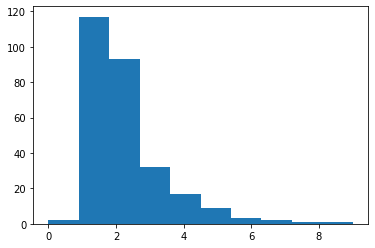

In [61]:
plt.hist(y_train_surv[0])

In [10]:
# make train and validation datasets with tuplefy
train = tt.tuplefy(x_train, (y_train_surv, x_train))
val = tt.tuplefy(x_val, (y_val_surv, x_val))

In [11]:
durations_test1, events_test1 = get_target(df_test1)
durations_test2, events_test2 = get_target(df_test2)

In [12]:
# set arch
in_features = x_train.shape[1]
encoded_features = 64
out_features = labtrans.out_features
netaesurv = NetAESurv(in_features, encoded_features, out_features)

In [13]:
netaesurv

NetAESurv(
  (encoder): Sequential(
    (0): Linear(in_features=409, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=2048, bias=True)
    (9): ReLU()
    (10): Linear(in_features=2048, out_features=409, bias=True)
  )
  (survnet): Sequen

In [14]:
from torchsummary import summary
summary(model=netaesurv, input_size=(1, in_features))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 2048]         839,680
              ReLU-2              [-1, 1, 2048]               0
            Linear-3              [-1, 1, 1024]       2,098,176
              ReLU-4              [-1, 1, 1024]               0
            Linear-5               [-1, 1, 512]         524,800
              ReLU-6               [-1, 1, 512]               0
            Linear-7               [-1, 1, 256]         131,328
              ReLU-8               [-1, 1, 256]               0
            Linear-9               [-1, 1, 128]          32,896
             ReLU-10               [-1, 1, 128]               0
           Linear-11                [-1, 1, 64]           8,256
           Linear-12               [-1, 1, 128]           8,320
             ReLU-13               [-1, 1, 128]               0
           Linear-14               [-1,

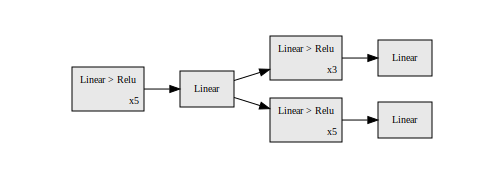

In [15]:
import hiddenlayer as hl
hl.build_graph(netaesurv, torch.zeros([1, in_features]))

In [16]:
# loss
loss = LossAELogHaz(0.6)

In [17]:
loss

LossAELogHaz(
  (loss_surv): NLLLogistiHazardLoss()
  (loss_ae): MSELoss()
)

In [64]:
print(labtrans.cuts)

[  0.          19.44444444  38.88888889  58.33333333  77.77777778
  97.22222222 116.66666667 136.11111111 155.55555556 175.        ]


In [65]:
# model
model = LogisticHazard(net=netaesurv, optimizer=tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss=loss)

In [66]:
dl = model.make_dataloader(train, batch_size=5, shuffle=False)
batch = next(iter(dl))

In [67]:
batch.shapes()

(torch.Size([5, 409]),
 ((torch.Size([5]), torch.Size([5])), torch.Size([5, 409])))

In [69]:
model.compute_metrics(batch)

{'loss': tensor(0.8454, grad_fn=<AddBackward0>)}

In [70]:
model.score_in_batches(*train)

{'loss': 1.0132696628570557}

In [71]:
# metrics
metrics = dict(loss_surv=LossAELogHaz(1), loss_ae=LossAELogHaz(0))

# callbacks
callbacks = [tt.cb.EarlyStopping()]

# cycling
batch_size = 5
epochs = 100

# trainning model
log = model.fit(
    *train, batch_size=batch_size, epochs=epochs,  verbose=True, val_data=val, metrics=metrics
)

0:	[6s / 6s],		train_loss: 1.0176,	train_loss_surv: 1.0274,	train_loss_ae: 1.0029,	val_loss: 1.0719,	val_loss_surv: 1.2405,	val_loss_ae: 0.8191
1:	[6s / 12s],		train_loss: 1.0116,	train_loss_surv: 1.0196,	train_loss_ae: 0.9996,	val_loss: 1.0730,	val_loss_surv: 1.2423,	val_loss_ae: 0.8192
2:	[6s / 18s],		train_loss: 1.0228,	train_loss_surv: 1.0376,	train_loss_ae: 1.0007,	val_loss: 1.0741,	val_loss_surv: 1.2442,	val_loss_ae: 0.8191
3:	[6s / 24s],		train_loss: 1.0193,	train_loss_surv: 1.0301,	train_loss_ae: 1.0032,	val_loss: 1.0891,	val_loss_surv: 1.2691,	val_loss_ae: 0.8192
4:	[6s / 31s],		train_loss: 1.0204,	train_loss_surv: 1.0292,	train_loss_ae: 1.0071,	val_loss: 1.0860,	val_loss_surv: 1.2638,	val_loss_ae: 0.8192
5:	[6s / 37s],		train_loss: 1.0255,	train_loss_surv: 1.0358,	train_loss_ae: 1.0101,	val_loss: 1.0862,	val_loss_surv: 1.2641,	val_loss_ae: 0.8193
6:	[6s / 43s],		train_loss: 1.0170,	train_loss_surv: 1.0286,	train_loss_ae: 0.9996,	val_loss: 1.0770,	val_loss_surv: 1.2487,	val_lo

In [20]:
res = model.log.to_pandas()

In [21]:
res.tail(20)

,train_loss,train_loss_surv,train_loss_ae,val_loss,val_loss_surv,val_loss_ae
80,1.019682,1.030987,1.002724,1.077247,1.249350,0.819092
81,1.011911,1.020015,0.999754,1.081338,1.256185,0.819067
82,1.021155,1.029666,1.008388,1.071684,1.240053,0.819130
83,1.023669,1.039323,1.000188,1.072538,1.241522,0.819062
84,1.021813,1.037345,0.998514,1.084047,1.260556,0.819283
85,1.028702,1.042594,1.007863,1.088822,1.268682,0.819030
86,1.022554,1.034734,1.004283,1.077639,1.250061,0.819006
87,1.013611,1.023559,0.998689,1.083238,1.259463,0.818901
88,1.020894,1.030691,1.006197,1.098972,1.285596,0.819036
89,1.021801,1.031634,1.007051,1.085551,1.263018,0.819350


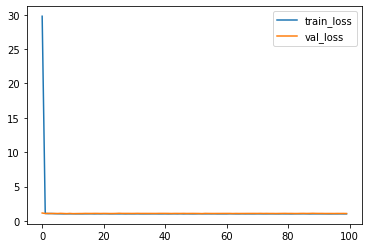

In [22]:
_ = res[['train_loss', 'val_loss']].plot()

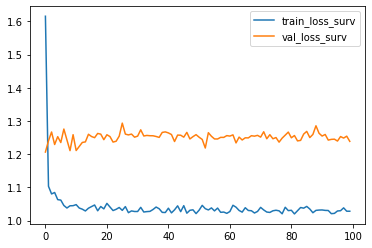

In [23]:
_ = res[['train_loss_surv', 'val_loss_surv']].plot()

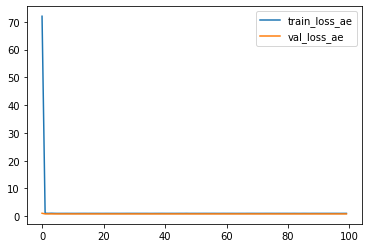

In [24]:
_ = res[['train_loss_ae', 'val_loss_ae']].plot()

In [25]:
surv1 = model.interpolate(10).predict_surv_df(x_test1)
surv2 = model.interpolate(10).predict_surv_df(x_test2)

In [26]:
surv1.iloc[:, :5]

,0,1,2,3,4
0.000000,0.996464,0.996464,0.996464,0.996464,0.996464
1.944444,0.978766,0.978766,0.978766,0.978766,0.978766
3.888889,0.961068,0.961068,0.961068,0.961068,0.961068
5.833333,0.943371,0.943371,0.943371,0.943371,0.943371
7.777778,0.925673,0.925673,0.925673,0.925673,0.925673
...,...,...,...,...,...
167.222222,0.119449,0.119449,0.119449,0.119449,0.119449
169.166667,0.119408,0.119408,0.119408,0.119408,0.119408
171.111111,0.119367,0.119367,0.119367,0.119367,0.119367
173.055556,0.119327,0.119327,0.119327,0.119327,0.119327


In [43]:
surv2.iloc[:, :10]

,0,1,2,3,4,5,6,7,8,9
0.000000,0.996464,0.996464,0.996464,0.996464,0.996464,0.996464,0.996464,0.996464,0.996464,0.996464
1.944444,0.978766,0.978766,0.978766,0.978766,0.978766,0.978766,0.978766,0.978766,0.978766,0.978766
3.888889,0.961068,0.961068,0.961068,0.961068,0.961068,0.961068,0.961068,0.961068,0.961068,0.961068
5.833333,0.943371,0.943371,0.943371,0.943371,0.943371,0.943371,0.943371,0.943371,0.943371,0.943371
7.777778,0.925673,0.925673,0.925673,0.925673,0.925673,0.925673,0.925673,0.925673,0.925673,0.925673
...,...,...,...,...,...,...,...,...,...,...
167.222222,0.119449,0.119449,0.119449,0.119449,0.119449,0.119449,0.119449,0.119449,0.119449,0.119449
169.166667,0.119408,0.119408,0.119408,0.119408,0.119408,0.119408,0.119408,0.119408,0.119408,0.119408
171.111111,0.119367,0.119367,0.119367,0.119367,0.119367,0.119367,0.119367,0.119367,0.119367,0.119367
173.055556,0.119327,0.119327,0.119327,0.119327,0.119327,0.119327,0.119327,0.119327,0.119327,0.119327


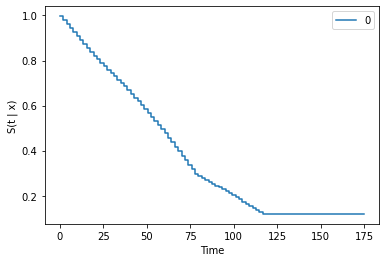

In [28]:
surv1.iloc[:, :1].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

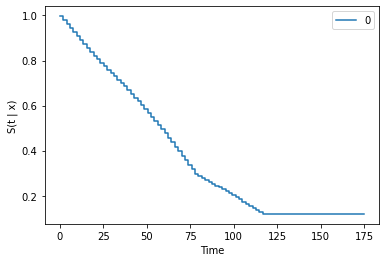

In [29]:
surv2.iloc[:, :1].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [30]:
model.predict(x_test1[:2])

array([[-5.64119   , -1.532651  , -1.5031195 , -1.0528468 , -0.39590964,
        -0.8904455 , -0.28077158, -7.0450974 , -6.4705734 , -5.681347  ],
       [-5.64119   , -1.532651  , -1.5031195 , -1.0528468 , -0.39590964,
        -0.8904455 , -0.28077158, -7.0450974 , -6.4705734 , -5.681347  ]],
      dtype=float32)

In [45]:
model.predict_net(x_test1[:1])

(array([[-5.6411896 , -1.532651  , -1.5031195 , -1.0528468 , -0.39590967,
         -0.8904455 , -0.28077158, -7.045097  , -6.4705734 , -5.681347  ]],
       dtype=float32),
 array([[ 7.51444604e-04,  1.16283717e-02, -1.55509943e-02,
          1.18611082e-02,  8.74233712e-03,  7.37010129e-03,
         -1.68504789e-02,  4.83422447e-03, -1.09395920e-03,
          1.00522032e-02, -3.12661566e-02,  7.28492904e-03,
          1.74768120e-02, -1.57339573e-02, -8.38837307e-03,
          2.63357200e-02,  2.17192387e-03,  1.33196227e-02,
         -8.57301801e-03,  3.19602378e-02, -1.16889216e-02,
          3.59406881e-03, -1.62226371e-02, -9.36655793e-03,
         -1.45846643e-02,  1.26127992e-02,  1.30299740e-02,
         -2.23490316e-03,  3.87337198e-03, -1.67614059e-03,
         -8.70321691e-03,  3.98859335e-03, -2.00624987e-02,
         -8.32182914e-03,  4.51640645e-03, -3.14249331e-03,
         -1.32361539e-02, -4.00260463e-03,  6.19061012e-03,
         -1.25289597e-02, -8.94838013e-05,  1.9

In [46]:
evs1 = EvalSurv(surv1, durations_test1, events_test1, censor_surv='km')
evs2 = EvalSurv(surv2, durations_test2, events_test2, censor_surv='km')

In [47]:
evs1.concordance_td()

0.5

In [48]:
evs2.concordance_td()

0.508686210640608

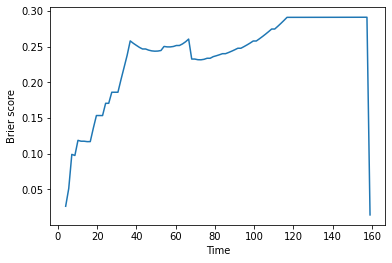

In [49]:
time_grid = np.linspace(durations_test1.min(), durations_test1.max(), 100)
evs1.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

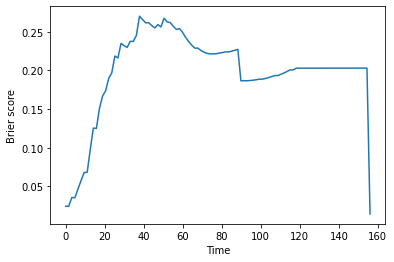

In [50]:
time_grid = np.linspace(durations_test2.min(), durations_test2.max(), 100)
evs2.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

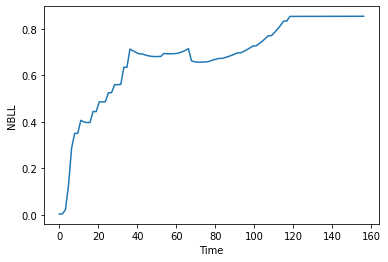

In [51]:
evs1.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

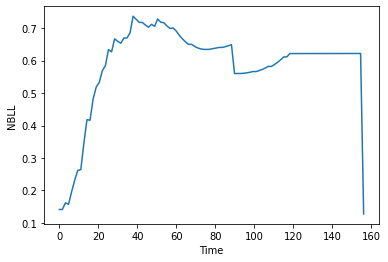

In [52]:
evs2.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [53]:
evs1.integrated_brier_score(time_grid)

0.23266189374059273

In [54]:
evs1.integrated_nbll(time_grid)

0.6736338200650821

In [55]:
evs2.integrated_brier_score(time_grid)

0.19932280323897467

In [56]:
evs2.integrated_nbll(time_grid)

0.5894982134535622